<center>
<h1 style="color:red; font-size:70px;"> Esercitazione 8</h1>

In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tensorflow import keras
from keras.datasets import cifar10
from tensorflow.keras import layers, activations

from keras.layers import Input, Flatten, Dense, Rescaling, MaxPooling2D, Conv2D, Dropout, RandomFlip, RandomRotation, RandomZoom

2025-07-05 09:33:04.187478: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-05 09:33:05.459009: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-05 09:33:06.101996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751700786.604677    3400 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751700786.767103    3400 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751700787.915417    3400 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

<h1 style="color: blue; font-size:50px;"> Esercizio 1 - Data augmentation</h1>

L'obiettivo di questo esercizio è vedere in azione la tecnica del "data augmentation", che consente di aumentare artificialmente la quantità di dati disponibili per l'addestramento di un modello, senza che debbano essere raccolti nuovi dati reali. Questo consente di migliorare la performance del modello ed allo stesso tempo di ridurre il rischio di overfitting (in quanto è più difficile che il modello impari troppo bene i dati d'addestramento). Nel campo delle immagini solitamente per aumentare la dimensione del campione si fa uso di:

- rotazioni

- riflessioni

- zoom o ritagli

- variazioni di luminosità o contrasto

- traslazioni

- aggiunta di rumore

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


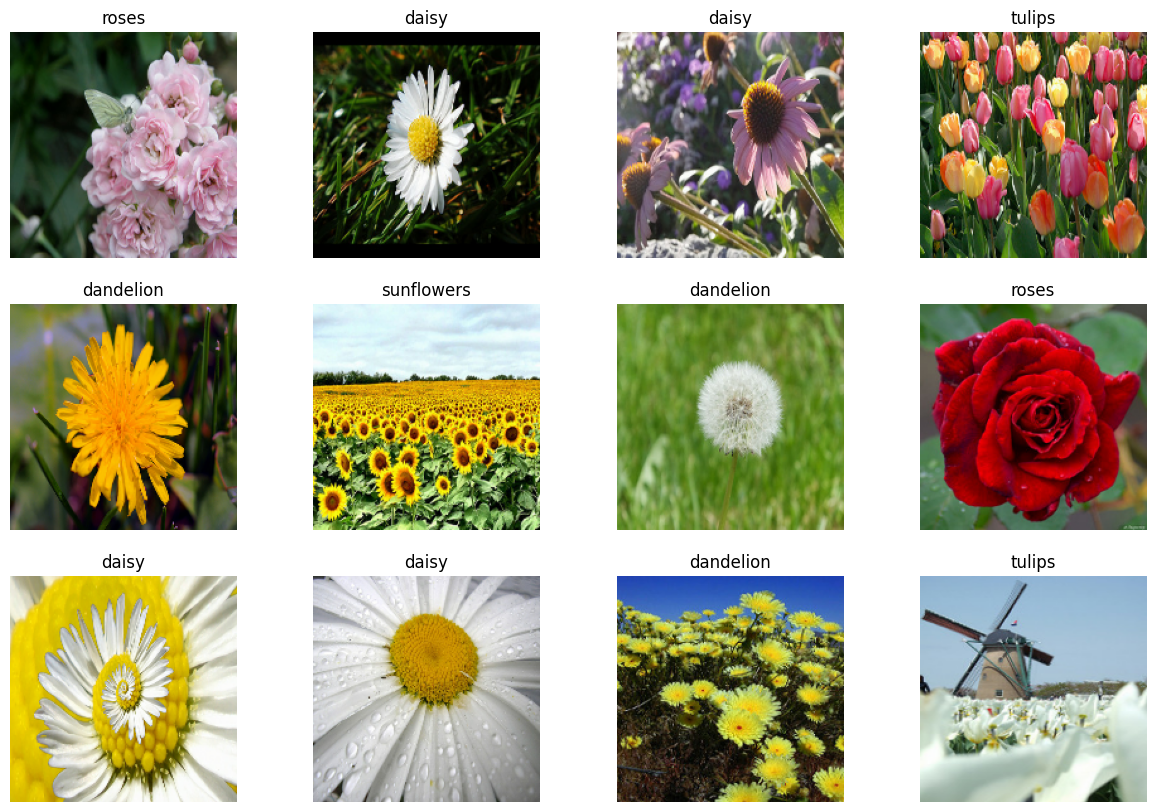

Dimensione batch foto:  (32, 180, 180, 3)
Dimensione batch labels:  (32,)
Epoch 1/8


/home/filippo/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2025-07-04 17:35:09.239124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:1443: Filling up shuffle buffer (this may take a while): 42 of 1000
2025-07-04 17:35:19.323649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:1443: Filling up shuffle buffer (this may take a while): 77 of 1000
2025-07-04 17:35:23.681548: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 510s 5s/step - accuracy: 0.3000 - loss: 2.9557 - val_accuracy: 0.4169 - val_loss: 1.2923
Epoch 2/8
 4/92 ━━━━━━━━━━━━━━━━━━━━ 33:17 23s/step - accuracy: 0.5768 - loss: 1.1505

In [ ]:
def builMod(imH, imW, numcl):
    # Funzione per costruire il modello in questione. 

    model = keras.Sequential()
    model.add(Rescaling(1./255, input_shape=(imH, imW, 3)))

    # Utilità del padding è la gestione dei pixel di bordo dell'immagine
    model.add(Conv2D(16, (3, 3), padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))

    model.add(Flatten())
    
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(numcl, activation = 'softmax'))
    
    return model

def plotTrInfo(hist):
    # Funzione per graficare l'evoluzione di loss ed accuracy in fase di allenamento
    fig, ax = plt.subplots(2, 1, figsize=(15,14))

    dim = len(hist.history['loss'])
    lab = ['loss', 'accuracy']

    for i, l in enumerate(lab):
        ax[i].plot(np.linspace(1, dim, dim), hist.history[l], color = 'darkblue', label = "Training " + l)
        ax[i].plot(np.linspace(1, dim, dim), hist.history['val_'+l], color = 'darkred', label = "Validation " + l)
        ax[i].set_title("Andamento " + l)
        ax[i].set_xlabel("Epoche")
        ax[i].set_ylabel(l)

        ax[i].legend(loc="best")
        ax[i].grid(True)
    plt.show()

def plotTrIm(model, val_ds, class_names):
    # Stampo tentativi di guess
    for im, lab in val_ds.take(1):
        plt.figure(figsize=(15, 10))

        for i in range(12):
            ax = plt.subplot(3, 4, i + 1)
            labP = model.predict(np.expand_dims(im[i], axis=0))
            plt.imshow(im[i].numpy().astype("uint8"))

            # Scelgo colore del titolo in base a correttezza
            # o meno della guess
            if class_names[np.argmax(labP)] == class_names[lab[i].numpy()]:
                color = 'green'
            else:
                color = 'red'

            ax.set_title(class_names[np.argmax(labP)], color = color)
            plt.axis("off")

        plt.show()


# Come primo step per la risoluzione dell'esercizio importo il dataset sul quale vogliamo allenare una 
# rete neurale pensata per risolvere un problema di classificazione. Nello specifico sono 3670 immagini 
# di fiori, ciascuna delle quali è un tensore tridimensionale di (180, 180, 3) pixel. Per caricare il 
# dataset scarichiamo una cartella compressa e la decomprimiamo. Il metodo keras.utils.get_file restituisce 
# il percorso alla cartella in cui si trovano i file estratti, di modo che lo si possa fornire a .Path(), 
# che è un metodo di pathlib, una libreria utile per gestire i percorsi dei file.
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)/ "flower_photos"


# Vogliamo ora procedere con il caricamento del dataset mediante keras.utils.image_dataset_from_directory
# che restituisce un tf.data.Dataset, che può essere alimentato direttamente nel modello per l'addestramento. 
# E' fondamentale specificare la validation_split, ossia la frazione di dati che vanno a costituire il training 
# e la validation.
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset="training",
    seed=0, image_size=(180, 180), batch_size=32
)
class_names = train_ds.class_names

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset="validation",
    seed=0, image_size=(180, 180), batch_size=32
)


# Stampo immagini di fiori per visualizzare parte del dataset
for im, lab in train_ds.take(1):
    plt.figure(figsize=(15, 10))

    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(im[i].numpy().astype("uint8"))
        ax.set_title(class_names[lab[i].numpy()])
        plt.axis("off")

    plt.show()

# Stampo dimensioni dei vari batch  
for imB, labB in train_ds:
    print("Dimensione batch foto: ", imB.shape)
    print("Dimensione batch labels: ", labB.shape)
    break


# Cache e prefetch (servono per velocizzare caricameno dati e passaggio
# da un batch al seguente del dataset)
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

model = builMod(180, 180, len(class_names))
model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])
hist = model.fit(train_ds, validation_data=val_ds, epochs=8)

plotTrInfo(hist)
plotTrIm(model, val_ds, class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Epoch 1/8


2025-07-04 15:47:47.752262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:818: Filling up shuffle buffer (this may take a while): 43 of 1000
2025-07-04 15:47:57.769914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:818: Filling up shuffle buffer (this may take a while): 86 of 1000
2025-07-04 15:47:58.858416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 406s 4s/step - accuracy: 0.3667 - loss: 1.5732 - val_accuracy: 0.6022 - val_loss: 1.0532
Epoch 2/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 350s 4s/step - accuracy: 0.5737 - loss: 1.0538 - val_accuracy: 0.6144 - val_loss: 1.0112
Epoch 3/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 369s 4s/step - accuracy: 0.6331 - loss: 0.9317 - val_accuracy: 0.6335 - val_loss: 0.9678
Epoch 4/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 338s 4s/step - accuracy: 0.6515 - loss: 0.8465 - val_accuracy: 0.6580 - val_loss: 0.8963
Epoch 5/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 337s 4s/step - accuracy: 0.6923 - loss: 0.7857 - val_accuracy: 0.6458 - val_loss: 0.9922
Epoch 6/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 336s 4s/step - accuracy: 0.7038 - loss: 0.7452 - val_accuracy: 0.6948 - val_loss: 0.8651
Epoch 7/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 505s 6s/step - accuracy: 0.7431 - loss: 0.6707 - val_accuracy: 0.6798 - val_loss: 0.8354
Epoch 8/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 596s 6s/step - accuracy: 0.7230 - loss: 0.6917 - val_accuracy: 0.7016 - val_loss: 0.7969


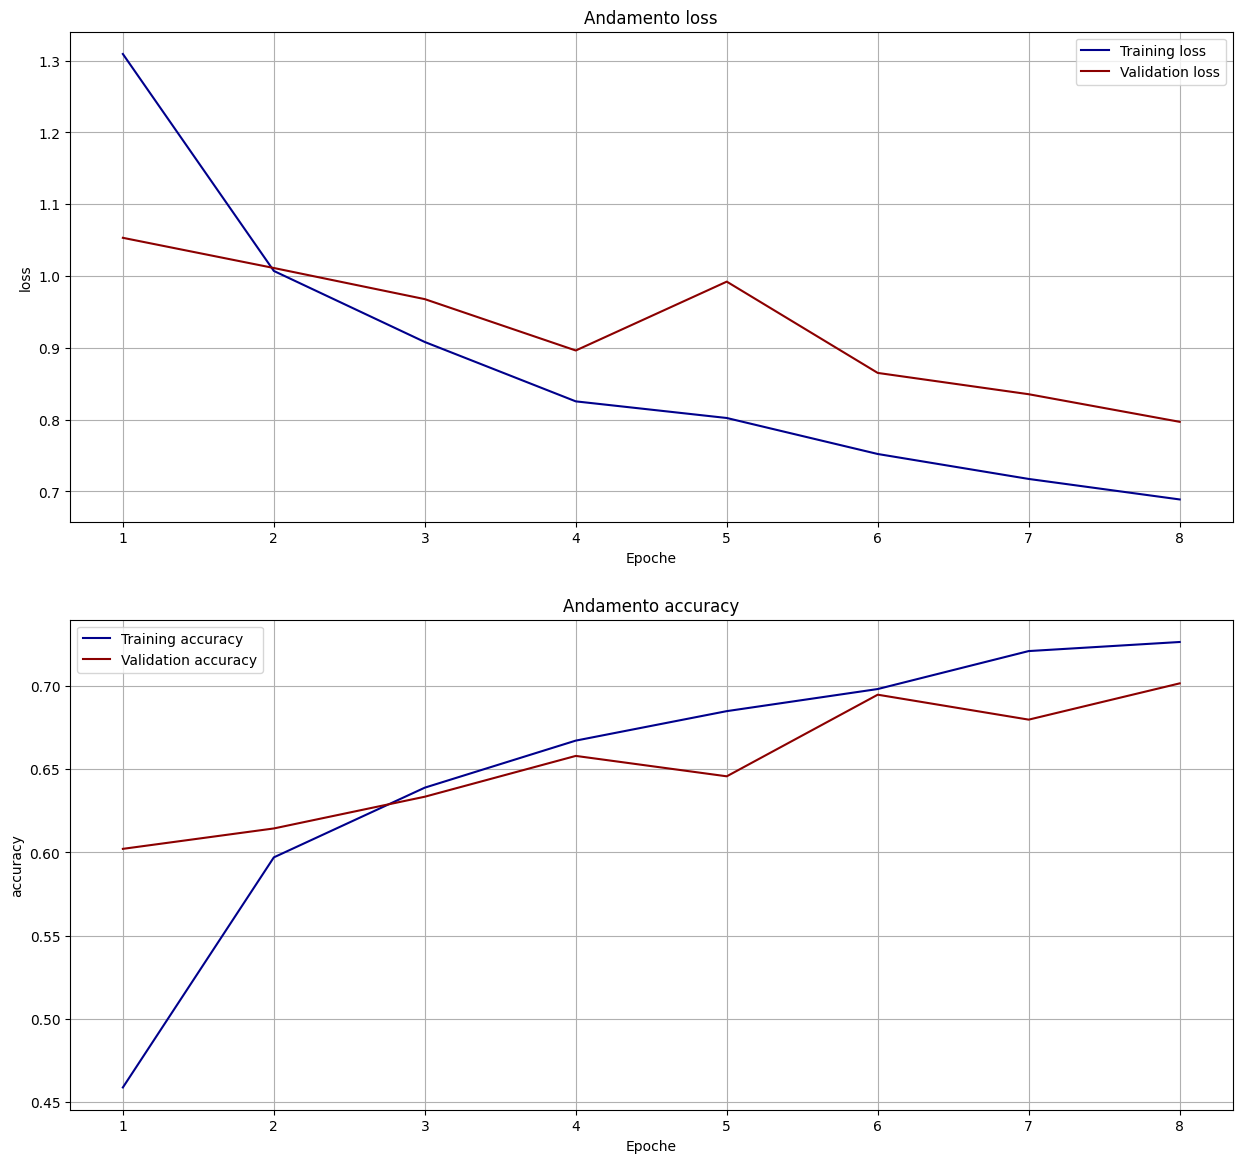

NameError: name 'valImg' is not defined

In [ ]:
def builMod(imH, imW, numcl):
    # Funzione per costruire il modello in questione. Adesso aggiungiamo dei layer
    # che consentano di fare data augmentation per migliorare le capacità predittive 
    # del modello

    model = keras.Sequential()

    # Sezione che performa data augmentation con 3 diverse operazioni: Randomflip, RandomRotation e RandomZoom
    model.add(RandomFlip("horizontal", input_shape = (imH, imW, 3)))
    model.add(RandomRotation(0.1))
    model.add(RandomZoom(0.1))

    model.add(Rescaling(1./255, input_shape=(imH, imW, 3)))

    # Utilità del padding è la gestione dei pixel di bordo dell'immagine
    model.add(Conv2D(16, (3, 3), padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))

    # Aggiungo uno strato di dropout per evitare overfitting del modello, molto
    # evidente nella casistica precedente
    model.add(Dropout(0.5))
    model.add(Flatten())
    
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(numcl, activation = 'softmax'))
    
    return model

def plotTrInfo(hist):
    # Funzione per graficare l'evoluzione di loss ed accuracy in fase di allenamento
    fig, ax = plt.subplots(2, 1, figsize=(15,14))

    dim = len(hist.history['loss'])
    lab = ['loss', 'accuracy']

    for i, l in enumerate(lab):
        ax[i].plot(np.linspace(1, dim, dim), hist.history[l], color = 'darkblue', label = "Training " + l)
        ax[i].plot(np.linspace(1, dim, dim), hist.history['val_'+l], color = 'darkred', label = "Validation " + l)
        ax[i].set_title("Andamento " + l)
        ax[i].set_xlabel("Epoche")
        ax[i].set_ylabel(l)

        ax[i].legend(loc="best")
        ax[i].grid(True)
    plt.show()

def plotTrIm(model, val_ds, class_names):
    # Stampo tentativi di guess
    for im, lab in val_ds.take(1):
        plt.figure(figsize=(15, 10))

        for i in range(12):
            ax = plt.subplot(3, 4, i + 1)
            labP = model.predict(np.expand_dims(im[i], axis=0))
            plt.imshow(im[i].numpy().astype("uint8"))

            # Scelgo colore del titolo in base a correttezza
            # o meno della guess
            if class_names[np.argmax(labP)] == class_names[lab[i].numpy()]:
                color = 'green'
            else:
                color = 'red'

            ax.set_title(class_names[np.argmax(labP)], color = color)
            plt.axis("off")

        plt.show()

# Scarico dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)/ "flower_photos"

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset="training",
    seed=0, image_size=(180, 180), batch_size=32
)
class_names = train_ds.class_names

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset="validation",
    seed=0, image_size=(180, 180), batch_size=32
)


# Cache e prefetch (servono per velocizzare caricameno dati e passaggio
# da un batch al seguente del dataset)
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

model = builMod(180, 180, len(class_names))
model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])
hist = model.fit(train_ds, validation_data=val_ds, epochs=8)

plotTrInfo(hist)
plotTrIm(model, val_ds, class_names)

<h1 style="color: blue; font-size:50px;"> Esercizio 2 - Tranfer learning</h1>

Il transfer learning è una tecnica del machine learning in cui un modello già addestrato su un compito viene riutilizzato (in parte o totalmente) per risolverne un altro, spesso correlato. Questa strategia è particolarmente utile quando si dispone di poche risorse di dati o tempo, ma si vuole comunque ottenere buoni risultati.

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Found 2000 files belonging to 2 classes.
Using 400 files for validation.


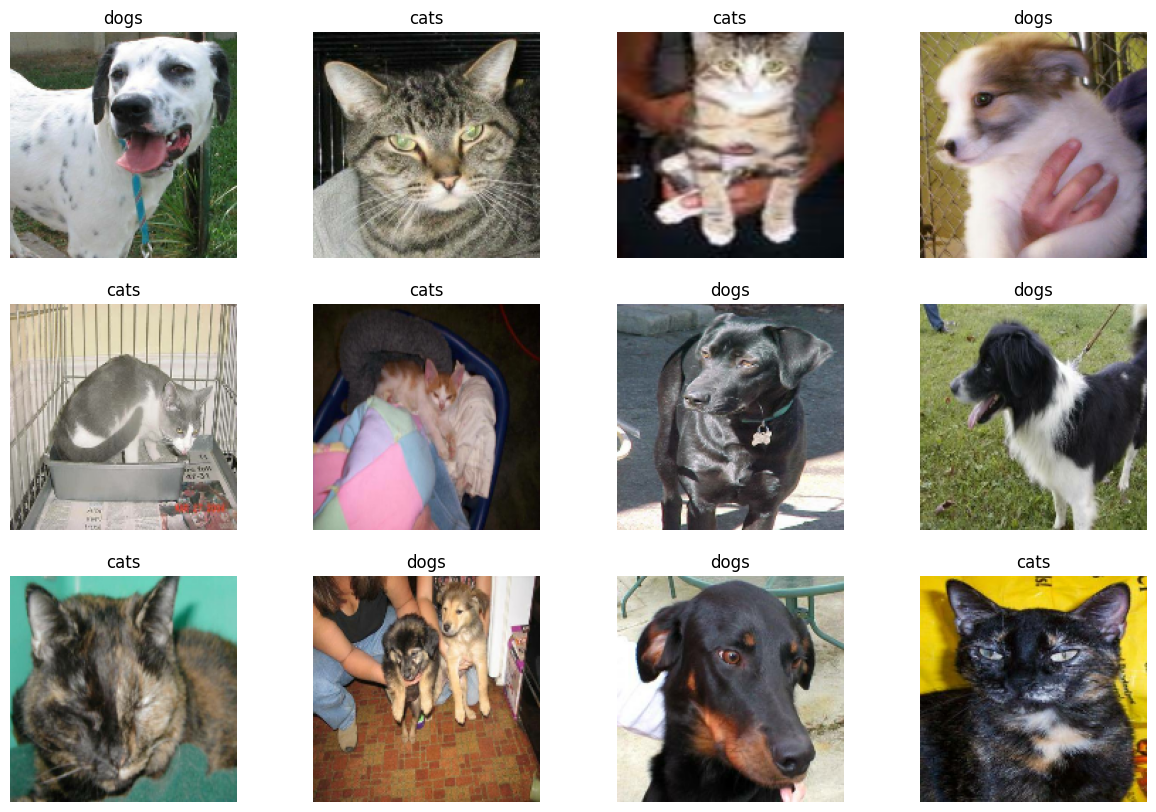

/home/filippo/.local/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


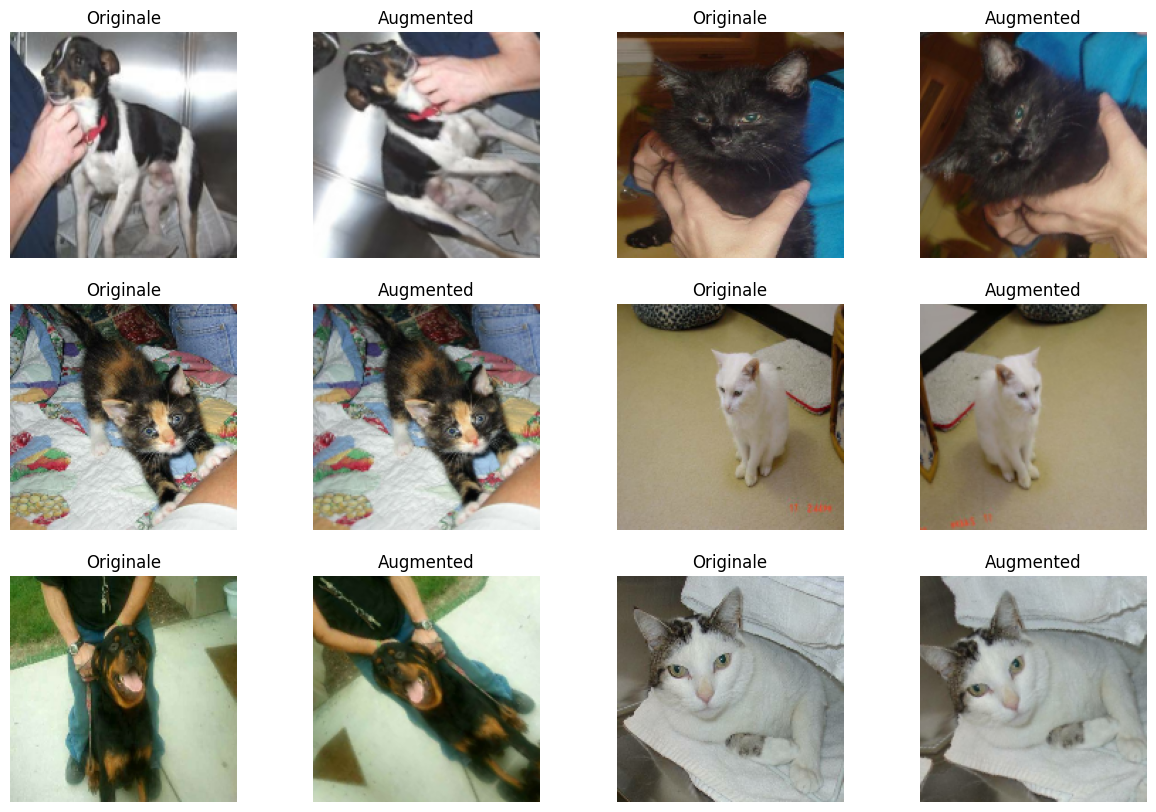

2025-07-05 10:57:58.070773: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
def printTrDat(train_ds):
    # Stampo immagini di fiori per visualizzare parte del dataset
    for im, lab in train_ds.take(1):
        plt.figure(figsize=(15, 10))

        for i in range(12):
            ax = plt.subplot(3, 4, i + 1)
            plt.imshow(im[i].numpy().astype("uint8"))
            ax.set_title(class_names[lab[i].numpy()])
            plt.axis("off")

        plt.show()

def augModel(imH, imW):
    # Funzione che costruisce un modello la cui unica task è quella di normalizzare i dati in 
    # ingresso ed effettuare "data augmentation". In particolare consideriamo riflessioni e 
    # rotazioni delle immagini. 
    model = keras.Sequential()

    # Sezione che performa data augmentation con 3 diverse operazioni: Randomflip, RandomRotation e RandomZoom
    model.add(RandomFlip("horizontal", input_shape = (imH, imW, 3)))
    model.add(RandomRotation(0.2))
    return model

def printAugImg(train_ds):
    # Funzione per stampare augmented images (ruotate e flippate). Come prima cosa 
    # costruisco il modello per fare data augmentation e poi stampo una accanto all'altra
    # immagine di partenza e quella ottenuta mediante data augemntation
    model = augModel(160, 160)
    model.trainable = True  

    for im, lab in train_ds.take(1):
        plt.figure(figsize=(15, 10))

        for i in range(6):
            ax = plt.subplot(3, 4, 2*i+1)
            plt.imshow(im[i].numpy().astype("uint8"))
            ax.set_title("Originale")
            plt.axis("off")

            ax = plt.subplot(3, 4, 2*i+2)
            plt.imshow(model(im[i:i+1], training=True)[0].numpy().astype("uint8"))
            ax.set_title("Augmented")
            plt.axis("off")

        plt.show()


# Carico il dataset e stampo alcune immagini per valutare il contenuto di quanto caricato
# Dopo questo primo semplice step definiamo un modello di data augmentation che consenta di 
# migliorare la variabilità del set e che di conseguenza porti ad una rete neurale con migliori 
# capacità di generalizzazione
dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=dataset_url, extract=True)
path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_extracted/cats_and_dogs_filtered')
train_dir = pathlib.Path(path) / 'train'
validation_dir = pathlib.Path(path) / 'validation'

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, validation_split=0.2, subset="training",
    seed=0, image_size=(160, 160), batch_size=32
)
class_names = train_ds.class_names

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, validation_split=0.2, subset="validation",
    seed=0, image_size=(160, 160), batch_size=32
)

printTrDat(train_ds)
printAugImg(train_ds)

Epoch 1/10


/home/filippo/.local/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - accuracy: 0.6126 - loss: 0.6486 - val_accuracy: 0.7025 - val_loss: 0.5171
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.7025 - loss: 0.5313 - val_accuracy: 0.7900 - val_loss: 0.4069
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 154s 3s/step - accuracy: 0.7672 - loss: 0.4330 - val_accuracy: 0.8425 - val_loss: 0.3317
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.8140 - loss: 0.3720 - val_accuracy: 0.8700 - val_loss: 0.2807
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 154s 3s/step - accuracy: 0.8507 - loss: 0.3274 - val_accuracy: 0.8900 - val_loss: 0.2454
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.8622 - loss: 0.3068 - val_accuracy: 0.9150 - val_loss: 0.2196
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.8824 - loss: 0.2756 - val_accuracy: 0.9225 - val_loss: 0.1993
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.8850 - loss: 0.2550 - val_accuracy: 0.9350 - val_loss: 0.

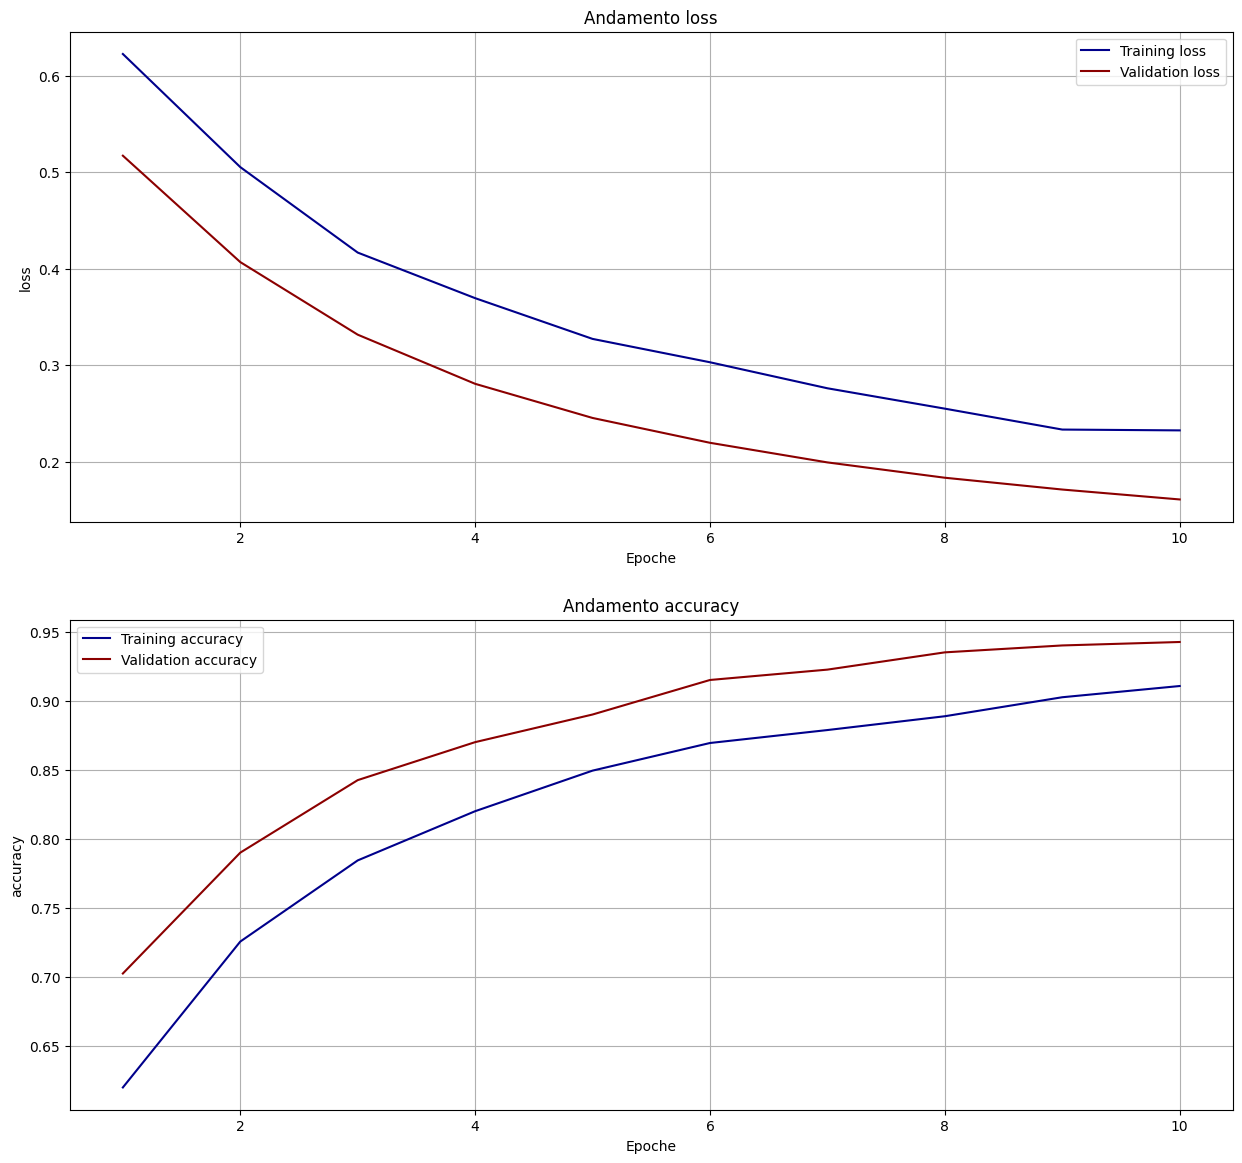

In [15]:
# Procediamo ora a costruire il modello vero e proprio, caratterizzato da un layer che fa data augmentation, una
# parte di preprocessing, la feature extraction e poi un dense layer per avere l'output
def trMod(featMod):
    # Funzione per la costruzione del modello
    inputs = Input(shape = (160, 160, 3))

    # Augmentation e preprocessing
    x = augModel(160, 160)(inputs)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

    # Feature extraction & media locale
    x = featMod(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Dropout & layer denso
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Vogliamo sfruttare una rete già allenata per risolvere il nostro problema di classificazione 
# Per fare questo inizializziamo un modello con una rete MobileNetV2, che è una rete neurale convoluzionale 
# leggera e veloce, progettata da Google per essere efficiente su dispositivi mobili. Nella seguente inizializzazione 
# abbiamo scelto l'opzione include_top = False perchè vogliamo rimuovere gli strati finali di classificazione del 
# modello, tenendo solamente il feature extractor. Inoltre chiamiamo base_model.trainable = False in modo tale da 
# congelare il modello 
featMod = tf.keras.applications.MobileNetV2(input_shape = (160, 160, 3), include_top = False, weights = 'imagenet')
featMod.trainable = False


# Inizializzazione del modello
model = trMod(featMod)
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4), 
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), 
    metrics = ['accuracy']
)
hist = model.fit(train_ds, validation_data=val_ds, epochs=10)

plotTrInfo(hist)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


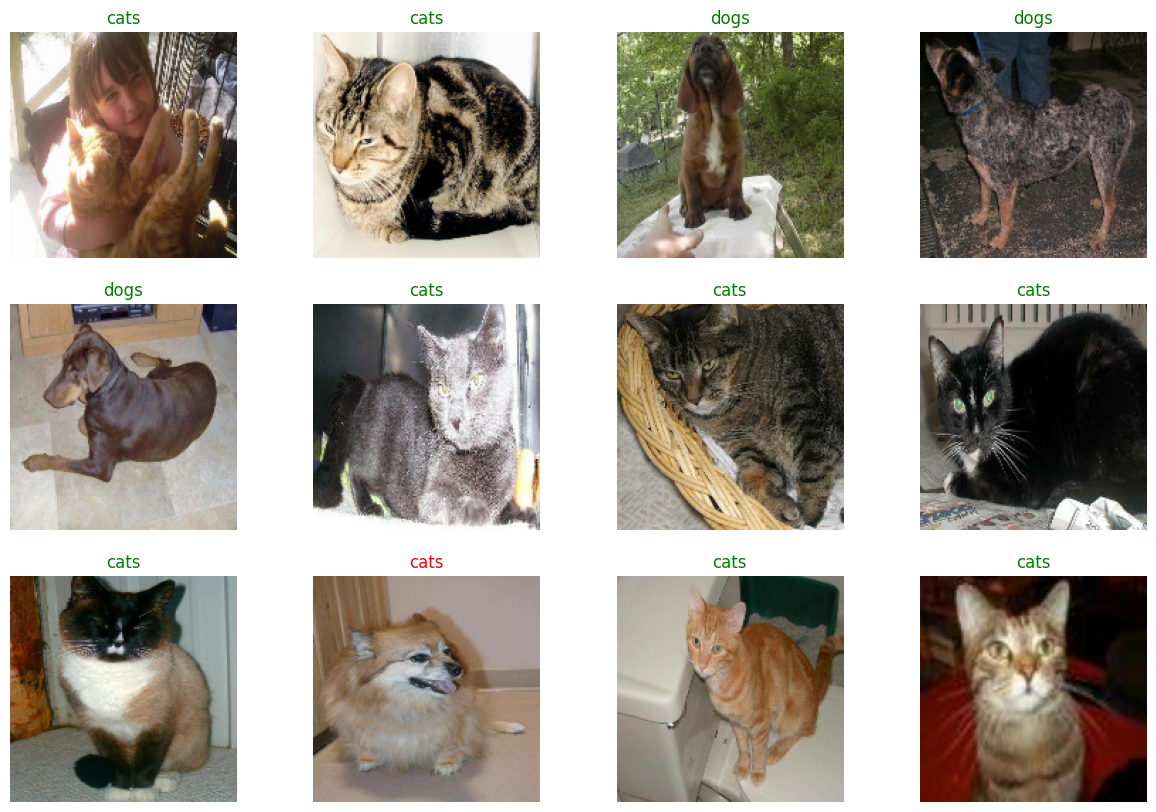

In [16]:
def plotTrIm(model, val_ds, class_names):
    # Stampo tentativi di guess
    for im, lab in val_ds.take(1):
        plt.figure(figsize=(15, 10))

        for i in range(12):
            ax = plt.subplot(3, 4, i + 1)
            labP = model.predict(np.expand_dims(im[i], axis=0))

            if labP[0] >= 0:
                labP = 1
            else:
                labP = 0

            plt.imshow(im[i].numpy().astype("uint8"))

            # Scelgo colore del titolo in base a correttezza
            # o meno della guess
            if class_names[labP] == class_names[lab[i].numpy()]:
                color = 'green'
            else:
                color = 'red'

            ax.set_title(class_names[labP], color = color)
            plt.axis("off")

        plt.show()

plotTrIm(model, val_ds, class_names)